# **4. Feature Engineering**

## <u> Read preprocessed files </u>

In [ ]:
order_products_prior_merged = pd.read_pickle('/content/drive/MyDrive/Instacart/order_products_prior_merged.pickle')
orders = pd.read_csv('/content/drive/MyDrive/Instacart/orders.csv' )
products = pd.read_csv('/content/drive/MyDrive/Instacart/products.csv' )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
print("No:of unique users: {:,d}".format(orders.user_id.nunique()))
print("No:of unique orders: {:,d}".format(orders.order_id.nunique()))

No:of unique users: 206,209
No:of unique orders: 3,421,083


In [ ]:
print("Total Orders in Prior : {:,d}".format(orders.eval_set.value_counts().loc['prior']))
print("Total Orders in Train : {:,d}".format(orders.eval_set.value_counts().loc['train']))
print("Total Orders in Test : {:,d}".format(orders.eval_set.value_counts().loc['test']))
print("Total Orders in Train & Test : {:,d}".format(orders.eval_set.value_counts().loc['train']+orders.eval_set.value_counts().loc['test']))

Total Orders in Prior : 3,214,874
Total Orders in Train : 131,209
Total Orders in Test : 75,000
Total Orders in Train & Test : 206,209


* There are total 3,421,083 orders.
* 3,214,874 orders in prior and the last order of each user is split between train and test (206,209 orders corresponding to 206,209 users)


**Verifying last order for users**

In [ ]:
orders[orders.user_id == 1]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


> Last order_number for user 1 is 11, which is in the train set

In [ ]:
orders[orders.user_id == 3]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
26,1374495,3,prior,1,1,14,NaN
27,444309,3,prior,2,3,19,9.0
28,3002854,3,prior,3,3,16,21.0
29,2037211,3,prior,4,2,18,20.0
30,2710558,3,prior,5,0,17,12.0
31,1972919,3,prior,6,0,16,7.0
32,1839752,3,prior,7,0,15,7.0
33,3225766,3,prior,8,0,17,7.0
34,3160850,3,prior,9,0,16,7.0
35,676467,3,prior,10,3,16,17.0


> last order_number for user 3 is 13, which is in the test set

## <u> Creating Train & Test Datasets </u>

Order table contains eval_set with
* prior - prior order of users, for feature engineering
* train - for training the model
* test  - for testing the model (for kaggle submission, we do not have labels for this 75K records)



Now we have to generate train and test datasets for training the maching learning model.

<u> **Process** </u>  <br> 
1. For each user, get the products purchased by users in prior order dataset (order_products_prior_merged)
2. Create features from the prior orders, we can have 4 types of features
    *   User Related Features
    *   Order Related Featues
    *   Product Related Featues
    *   User & Product related Features
3. Create the predicted variable **in_last_order** , merge the dataset with order_products_train. if there product is reordered in this dataset for the user --> in_last_order = 1 else 0 in our final dataset.

<u> **Format of train & test dataset** </u>
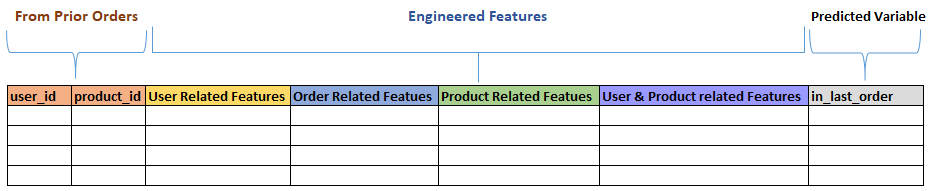



### <u> Prior orders for users

In [ ]:
#generates dataframe with prior ordered items by users along with other features specific to user-product
order_products_prior_merged = order_products_prior_merged.merge(products[['product_id','product_name']],on = 'product_name', how = 'inner')
prior_data = order_products_prior_merged.groupby(['user_id','product_name','product_id','department','aisle']).agg(mean_add_to_cart = ('add_to_cart_order','mean')).reset_index()
prior_data['mean_add_to_cart'] = prior_data['mean_add_to_cart'].astype(int)   
prior_data.head()                                                

,user_id,product_name,product_id,department,aisle,mean_add_to_cart
0,1,0% Greek Strained Yogurt,38928,dairy eggs,yogurt,4
1,1,Aged White Cheddar Popcorn,26088,snacks,popcorn jerky,4
2,1,Bag of Organic Bananas,13176,produce,fresh fruits,6
3,1,Bartlett Pears,41787,produce,fresh fruits,7
4,1,Cinnamon Toast Crunch,13032,breakfast,cereal,6


> **user_id, product_name, department, aisle** from prior orders <br>
> **mean_add_to_cart_order** - mean position of the product in user's cart

### <u> Order Related Features

In [ ]:
def order_features(orders, prior_data,prior_preprocessed ) :
  #merge with orders table to get last order number and order details for the user
  data = prior_data.merge(orders, on ='user_id', how = 'inner')
  #reordered percentage for day of week
  dow_reord = prior_preprocessed.groupby('order_dow').agg(dow_reord_pct = ('reordered','mean')).reset_index()
  data= data.merge(dow_reord, on ='order_dow',how = 'inner')
  #reordered percentage for hour of day
  hod_reord = prior_preprocessed.groupby('order_hour_of_day').agg(hod_reord_pct = ('reordered','mean')).reset_index()
  data= data.merge(hod_reord, on ='order_hour_of_day',how = 'inner')
  #reordered percentage for days since prior order
  dsp_reord = prior_preprocessed.groupby('days_since_prior_order').agg(dsp_reord_pct = ('reordered','mean')).reset_index()
  data= data.merge(dsp_reord, on ='days_since_prior_order',how = 'inner')
  #reordered percentage for day of week and hour of day combined
  dow_hod_reord = prior_preprocessed.groupby(['order_dow','order_hour_of_day']).agg(dow_hod_reord_pct = ('reordered','mean')).reset_index()
  data= data.merge(dow_hod_reord, on =['order_dow','order_hour_of_day'],how = 'inner')
  #reordered percentage for add to cart order
  atc_reord = prior_preprocessed.groupby('add_to_cart_order').agg(atc_reord_pct = ('reordered','mean')).reset_index()
  data= data.merge(atc_reord, left_on ='mean_add_to_cart',right_on = 'add_to_cart_order',how = 'inner')
  data.drop(columns = ['add_to_cart_order'],inplace = True)

  return data

In [ ]:
train_data = order_features(train_orders, prior_data,order_products_prior_merged )
test_data = order_features(test_orders, prior_data,order_products_prior_merged )
train_data.head()

,user_id,product_name,product_id,department,aisle,mean_add_to_cart,order_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,dow_reord_pct,hod_reord_pct,dsp_reord_pct,dow_hod_reord_pct,atc_reord_pct
0,1,0% Greek Strained Yogurt,38928,dairy eggs,yogurt,4,1187899,train,11,4,8,14.0,0.590979,0.631883,0.628323,0.623302,0.636958
1,1,Aged White Cheddar Popcorn,26088,snacks,popcorn jerky,4,1187899,train,11,4,8,14.0,0.590979,0.631883,0.628323,0.623302,0.636958
2,1,Organic String Cheese,25133,dairy eggs,packaged cheese,4,1187899,train,11,4,8,14.0,0.590979,0.631883,0.628323,0.623302,0.636958
3,76,Clean Day Fabric Softener Lavender Scent,11984,household,laundry,4,3294399,train,10,4,8,14.0,0.590979,0.631883,0.628323,0.623302,0.636958
4,76,Homestyle Popcorn,25613,snacks,popcorn jerky,4,3294399,train,10,4,8,14.0,0.590979,0.631883,0.628323,0.623302,0.636958


> **order_id,	eval_set,	order_number,	order_dow,	order_hour_of_day,	days_since_prior_order** : From orders dataset, last order for user and order details <br>
> <u> For the last order of the user, calculate below reorder % </u> <br>
> **dow_reord_pct** : reordered % for the order dow <br>
>	**hod_reord_pct**	: reordered % for the hour of day <br>
> **dsp_reord_pct**	: reordered % for the days since prior order  of user<br>
> **dow_hod_reord_pct**	: reordered % for the hour of day & day of week  combined <br>
> **atc_reord_pct** : reordered % for add to cart order <br>


### <u> User-Product Related Features

In [ ]:
def user_product_features(data,prior_preprocessed,prior_order) :
  # orders, reorders  - count of orders/reorders by users with the product, reordered% of product by user, stats of add to cart order of product by user
  #last and first orders by user with the product
  prior = prior_preprocessed.groupby(['user_id','product_name']).agg(
    orders = ('product_name','count'),reorders = ('reordered','sum'),user_prod_reord_pct = ('reordered','mean'),median_add_to_cart = ('add_to_cart_order','median'),
    min_add_to_cart = ('add_to_cart_order','min'),max_add_to_cart = ('add_to_cart_order','max'),last_order_number = ('order_number','max'),
    first_order_number = ('order_number','min'),
    ).reset_index()
  data = data.merge(prior,on=['user_id','product_name'],how = 'inner')

  #number of orders since the product was last ordered by the user
  data['orders_since_last_ordered'] = data['order_number'] - data['last_order_number'] - 1
  #number of days since the product was last ordered by the user
  last_order_since = data[['user_id','last_order_number','order_number']].drop_duplicates()
  last_order_since_prod = orders.merge(last_order_since,on= 'user_id',how ='inner')
  last_order_since_prod = last_order_since_prod[(last_order_since_prod.order_number_x > last_order_since_prod.last_order_number) & (last_order_since_prod.order_number_x <= last_order_since_prod.order_number_y)]
  last_order_since_prod= last_order_since_prod.groupby(['user_id','last_order_number']).agg(days_since_prior_ord_prod = ('days_since_prior_order','sum')).reset_index()
  data = data.merge(last_order_since_prod,on=['user_id','last_order_number'],how = 'inner')

  #number of times product ordered by user in last 10 orders 
  last10orders = prior_order.groupby('user_id')['order_number'].nlargest(10).reset_index()
  last10orders1 = last10orders.merge(prior_order,on=['user_id','order_number'],how = 'inner')
  last_10_orders1 =last10orders1[['order_id']]
  order_products_last10 = prior_preprocessed[prior_preprocessed.order_id.isin(last_10_orders1.order_id)]
  # number of time the product was ordered by user in their last x orders(x = 2 to 10)
  for i in range(2,11):
    idx = order_products_last10.groupby('user_id')['order_number'].transform(max) -i   < order_products_last10['order_number'] 
    last_i_prods = order_products_last10[idx]
    if i == 3 :
      order_products_last3 = last_i_prods
    last_i_prods = last_i_prods.groupby(['user_id','product_name']).agg(count_last = ('product_name','count')).reset_index()
    last_i_prods.rename(columns={"count_last": "last"+str(i)+"_count"},inplace = True)
    data = data.merge(last_i_prods,on=['user_id','product_name'],how = 'left')
    data.fillna(0,inplace = True)
  #whether the product was ordered by user in last order, last - 1 order, last - 2 order
  for i in range(3):
    idx = order_products_last3.groupby('user_id')['order_number'].transform(max) - i  == order_products_last3['order_number'] 
    lasti = order_products_last3[idx]
    lasti = lasti.groupby(['user_id','product_name']).agg(last = ('product_name','count')).reset_index()
    lasti.rename(columns={"last": "last"+str(i+1)},inplace = True)
    data = data.merge(lasti,on = ['user_id','product_name'],how = 'left')
    data.fillna(0,inplace = True)
  return data


In [ ]:
prior_order = orders[orders['eval_set']== 'prior']
train_data = user_product_features(train_data,order_products_prior_merged,prior_order)
test_data = user_product_features(test_data,order_products_prior_merged,prior_order)
train_data.head()

,user_id,product_name,product_id,department,aisle,mean_add_to_cart,order_id,eval_set,order_number,order_dow,...,last4_count,last5_count,last6_count,last7_count,last8_count,last9_count,last10_count,last1,last2,last3
0,1,0% Greek Strained Yogurt,38928,dairy eggs,yogurt,4,1187899,train,11,4,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,1,Organic String Cheese,25133,dairy eggs,packaged cheese,4,1187899,train,11,4,...,4.0,5.0,6.0,7.0,8.0,8.0,8.0,1.0,1.0,1.0
2,1,Cinnamon Toast Crunch,13032,breakfast,cereal,6,1187899,train,11,4,...,2.0,2.0,2.0,2.0,2.0,3.0,3.0,1.0,0.0,0.0
3,1,Organic Unsweetened Almond Milk,35951,dairy eggs,soy lactosefree,7,1187899,train,11,4,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,1,Milk Chocolate Almonds,39657,snacks,candy chocolate,3,1187899,train,11,4,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [ ]:
train_data.columns

Index(['user_id', 'product_name', 'product_id', 'department', 'aisle',
       'mean_add_to_cart', 'order_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'dow_reord_pct',
       'hod_reord_pct', 'dsp_reord_pct', 'dow_hod_reord_pct', 'atc_reord_pct',
       'orders', 'reorders', 'user_prod_reord_pct', 'median_add_to_cart',
       'min_add_to_cart', 'max_add_to_cart', 'last_order_number',
       'first_order_number', 'orders_since_last_ordered',
       'days_since_prior_ord_prod', 'last2_count', 'last3_count',
       'last4_count', 'last5_count', 'last6_count', 'last7_count',
       'last8_count', 'last9_count', 'last10_count', 'last1', 'last2',
       'last3'],
      dtype='object')

> **orders, reorders**	: Number of the time the product was ordered/reordered by the user <br>
> **user_prod_reord_pct** : reordered% of the product by the user<br>
> **median_add_to_cart,min_add_to_cart,max_add_to_cart** : stats of add to cart of product by the user(including min, max and median) <br>
> **orders_since_last_ordered**	: Number of orders since the product was last ordered by the user <br>
> **days_since_prior_ord_prod** : Number of days since the product was last ordered by the user <br>
> **lastx_count** : number of time products was ordered in last x orders( x = 2 to 10) <br>
> **lastx** : flag indicating whether the product was ordered by the user in ther lastx order (x = 1,2,3)


### <u> Product Related Features

In [ ]:
def product_features(data,prior_preprocessed):
  # Total orders, reorders and reordered% of the product
  prod_reord = prior_preprocessed.groupby('product_name').agg(total_orders_p = ('reordered','count'),total_reorders_p = ('reordered','sum'),
                                                              prod_reord_pct = ('reordered','mean')).reset_index()
  data = data.merge(prod_reord, on ='product_name',how = 'inner')

  # reordered % for department
  dept_reord = prior_preprocessed.groupby('department').agg(dept_reord_pct = ('reordered','mean')).reset_index()
  data = data.merge(dept_reord, on ='department',how = 'inner')

  # reordered % for aisle
  aisl_reord = prior_preprocessed.groupby('aisle').agg(aisl_reord_pct = ('reordered','mean')).reset_index()
  data = data.merge(aisl_reord, on ='aisle',how = 'inner')

  # whether product is organic
  data['organic'] = np.where(data['product_name'].str.contains("organic",case = False), 1, 0)
  prior_preprocessed['organic'] = np.where(prior_preprocessed['product_name'].str.contains("organic",case = False), 1, 0)

  # organic product reordered %
  org_reord = prior_preprocessed.groupby('organic').agg(reord = ('reordered','mean')).reset_index()
  data['organic_reord'] = np.where(data['organic'] == 1 , org_reord[org_reord['organic']==1].reord, org_reord[org_reord['organic']==0].reord)

  # whether product is non vegetarian 
  data['vegetarian_prod'] = np.select([
  (data.department.str.contains('meat|seafood') == True) | 
  ((data.aisle.str.contains('meat|seafood|jerky') == True ) & (data.aisle.str.contains('marinades|alternatives') == False ) &
  (data.product_name.str.contains('popcorn',case = False) == False ))
  ], [0], default = 1)
  prior_preprocessed['vegetarian_prod'] = np.select([
  (prior_preprocessed.department.str.contains('meat|seafood') == True) | 
  ((prior_preprocessed.aisle.str.contains('meat|seafood|jerky') == True ) & (prior_preprocessed.aisle.str.contains('marinades|alternatives') == False ) &
  (prior_preprocessed.product_name.str.contains('popcorn',case = False) == False ))
  ], [0], default = 1)

  # reordered % for veg/non veg products
  veg_reord = prior_preprocessed.groupby('vegetarian_prod').agg(reord = ('reordered','mean')).reset_index()
  data['vegetarian_reord'] = np.where(data['vegetarian_prod'] == 1 , veg_reord[veg_reord['vegetarian_prod']==1].reord , veg_reord[veg_reord['vegetarian_prod']==0].reord)

  #most ordered day for the product
  most_oredered_day_p = prior_preprocessed.groupby(['product_name','order_dow']).agg(most_ord_day_count_p = ('order_dow','count')).reset_index()
  idx= most_oredered_day_p.groupby(['product_name'])['most_ord_day_count_p'].transform(max) == most_oredered_day_p['most_ord_day_count_p']
  most_oredered_day_p = most_oredered_day_p[idx]
  most_oredered_day_p = most_oredered_day_p.groupby('product_name').min().reset_index()
  most_oredered_day_p.rename(columns = {'order_dow':'most_ordered_day_p'}, inplace = True)
  data = data.merge(most_oredered_day_p,on='product_name',how = 'inner')

  #most ordered hour for product
  most_oredered_hour_p = prior_preprocessed.groupby(['product_name','order_hour_of_day']).agg(most_ord_hour_count_p = ('order_hour_of_day','count')).reset_index()
  idx= most_oredered_hour_p.groupby(['product_name'])['most_ord_hour_count_p'].transform(max) == most_oredered_hour_p['most_ord_hour_count_p']
  most_oredered_hour_p = most_oredered_hour_p[idx]
  most_oredered_hour_p = most_oredered_hour_p.groupby('product_name').min().reset_index()
  most_oredered_hour_p.rename(columns = {'order_hour_of_day':'most_ordered_hour_p'}, inplace = True)
  data = data.merge(most_oredered_hour_p,on='product_name',how = 'inner')

  #stats for orders since the product was last ordered by user(mean, median, min, max)
  orders_since_last_ordered_p = data[['product_name','orders_since_last_ordered']].groupby('product_name').agg(
         orders_since_last_ordered_p_mean = ('orders_since_last_ordered','mean'),orders_since_last_ordered_p_median = ('orders_since_last_ordered','median'),
         orders_since_last_ordered_p_max = ('orders_since_last_ordered','max')).reset_index()
  data = data.merge(orders_since_last_ordered_p, on = 'product_name',how = 'inner')

  #stats for days since the product was last ordered user(mean, median, min, max)
  days_since_prior_ord_prod_p = data[['product_name','days_since_prior_ord_prod']].groupby('product_name').agg(
         days_since_prior_ord_prod_p_mean = ('days_since_prior_ord_prod','mean'),days_since_prior_ord_prod_p_median = ('days_since_prior_ord_prod','median'),
         days_since_prior_ord_prod_p_min = ('days_since_prior_ord_prod','min'),days_since_prior_ord_prod_p_max = ('days_since_prior_ord_prod','max')).reset_index()
  data = data.merge(days_since_prior_ord_prod_p, on = 'product_name',how = 'inner')

  return data

In [ ]:
train_data = product_features(train_data,order_products_prior_merged)
test_data = product_features(test_data,order_products_prior_merged)
train_data.head()

,user_id,product_name,product_id,department,aisle,mean_add_to_cart,order_id,eval_set,order_number,order_dow,...,most_ord_day_count_p,most_ordered_hour_p,most_ord_hour_count_p,orders_since_last_ordered_p_mean,orders_since_last_ordered_p_median,orders_since_last_ordered_p_max,days_since_prior_ord_prod_p_mean,days_since_prior_ord_prod_p_median,days_since_prior_ord_prod_p_min,days_since_prior_ord_prod_p_max
0,1,0% Greek Strained Yogurt,38928,dairy eggs,yogurt,4,1187899,train,11,4,...,3377,10,1999,6.611034,2.0,87,80.408966,50.0,0.0,364.0
1,126208,0% Greek Strained Yogurt,38928,dairy eggs,yogurt,2,493810,train,5,4,...,3377,10,1999,6.611034,2.0,87,80.408966,50.0,0.0,364.0
2,166607,0% Greek Strained Yogurt,38928,dairy eggs,yogurt,3,976232,train,10,4,...,3377,10,1999,6.611034,2.0,87,80.408966,50.0,0.0,364.0
3,52341,0% Greek Strained Yogurt,38928,dairy eggs,yogurt,7,1653513,train,4,4,...,3377,10,1999,6.611034,2.0,87,80.408966,50.0,0.0,364.0
4,107764,0% Greek Strained Yogurt,38928,dairy eggs,yogurt,1,1856433,train,8,4,...,3377,10,1999,6.611034,2.0,87,80.408966,50.0,0.0,364.0


In [ ]:
train_data.columns

Index(['user_id', 'product_name', 'product_id', 'department', 'aisle',
       'mean_add_to_cart', 'order_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'dow_reord_pct',
       'hod_reord_pct', 'dsp_reord_pct', 'dow_hod_reord_pct', 'atc_reord_pct',
       'orders', 'reorders', 'user_prod_reord_pct', 'median_add_to_cart',
       'min_add_to_cart', 'max_add_to_cart', 'last_order_number',
       'first_order_number', 'orders_since_last_ordered',
       'days_since_prior_ord_prod', 'last2_count', 'last3_count',
       'last4_count', 'last5_count', 'last6_count', 'last7_count',
       'last8_count', 'last9_count', 'last10_count', 'last1', 'last2', 'last3',
       'total_orders_p', 'total_reorders_p', 'prod_reord_pct',
       'dept_reord_pct', 'aisl_reord_pct', 'organic', 'organic_reord',
       'vegetarian_prod', 'vegetarian_reord', 'most_ordered_day_p',
       'most_ord_day_count_p', 'most_ordered_hour_p', 'most_ord_hour_count_p',
       

For Products in prior order, create following fields
> **total_orders_p,total_reorders_p, prod_reord_pct** : total orders, total reorders and reordered % for the product <br>
> **dept_reord_pct**	: Reordered % of department to which product belongs to <br>
> **aisl_reord_pct** : Reordered % of aisle to which product belongs to <br>
> **organic** : Whether product is organic or not, this is a flag <br>
> **organic_reord** : Reordered % for organic/non organic product <br>
> **vegetarian_prod** : Whether product is vegetarian or not, this is a flag <br>
> **vegetarian_reord** : Reordered% for vegetarian/non vegetarian product <br>
> **most_ordered_day_p** : Day which the product gets ordered the most 	 	
> **most_ord_day_count_p** : Count of times the product was ordered on the most ordered day of the week <br>
> **most_ordered_hour_p** : Day which the product gets ordered the most <br>
> **most_ord_hour_count_p** : Count of times the product was ordered on the most ordered day of the week <br>
> **stats on orders_since_last_ordered** : stats on the orders since the product was last ordered by user (mean , median , max) <br>
> **stats on days_since_last_ordered** : stats on the days since the product was last ordered by user (mean , median , max, min) <br>



### <u> User Related Features

In [ ]:
def user_features(data,prior_preprocessed):
  #average products per order
  user_order_prod = prior_preprocessed.groupby(['user_id','order_id']).agg(product_count = ('product_name','count')).reset_index()
  user_order_prod = user_order_prod.groupby('user_id').agg(prod_per_order = ('product_count','mean')).reset_index().astype(int)
  data = data.merge(user_order_prod, on =  'user_id',how = 'inner')
  #most ordered day for user
  user_orders = prior_preprocessed[['user_id','order_id','order_dow','order_hour_of_day','days_since_prior_order']].drop_duplicates()
  most_oredered_day_u = user_orders.groupby(['user_id','order_dow']).agg(most_ord_day_count_u = ('order_dow','count')).reset_index()
  idx= most_oredered_day_u.groupby(['user_id'])['most_ord_day_count_u'].transform(max) == most_oredered_day_u['most_ord_day_count_u']
  most_oredered_day_u = most_oredered_day_u[idx]
  most_oredered_day_u = most_oredered_day_u.groupby('user_id').min().reset_index()
  most_oredered_day_u.rename(columns = {'order_dow':'most_ordered_day_u'}, inplace = True)
  data = data.merge(most_oredered_day_u,on='user_id',how = 'inner')
  #most ordered hour for user
  most_oredered_hour_u = user_orders.groupby(['user_id','order_hour_of_day']).agg(most_ord_hour_count_u = ('order_hour_of_day','count')).reset_index()
  idx= most_oredered_hour_u.groupby(['user_id'])['most_ord_hour_count_u'].transform(max) == most_oredered_hour_u['most_ord_hour_count_u']
  most_oredered_hour_u = most_oredered_hour_u[idx]
  most_oredered_hour_u = most_oredered_hour_u.groupby('user_id').min().reset_index()
  most_oredered_hour_u.rename(columns = {'order_hour_of_day':'most_ordered_hour_u'}, inplace = True)
  data = data.merge(most_oredered_hour_u,on='user_id',how = 'inner')
  #total products and distinct products ordered by user
  user_products = prior_preprocessed.groupby('user_id').agg(total_products_u = ('product_name','count'),
                                                            reordered_products_u = ('reordered','sum'), distinct_products =                                                            ('product_name','nunique'),user_reord_pct = ('reordered','mean')).reset_index()
  data = data.merge(user_products,on='user_id',how = 'inner')
  # Average days between order for a user and corresponding reorder %
  dsp_reord = prior_preprocessed.groupby('days_since_prior_order').agg(days_btwn_order_reord_pct = ('reordered','mean')).reset_index()
  mean_days_between_orders = prior_order.groupby('user_id').agg(mean_days_between_orders = ('days_since_prior_order','mean')).reset_index()
  data = data.merge(mean_days_between_orders,on='user_id',how = 'inner')
  data['mean_days_between_orders'] = data['mean_days_between_orders'].astype(int)
  data = data.merge(dsp_reord, left_on ='mean_days_between_orders', right_on ='days_since_prior_order',how = 'inner')
  data.rename(columns = {'days_since_prior_order_x': 'days_since_prior_order'},inplace = True)
  data.drop(columns = ['days_since_prior_order_y'],inplace = True)
  #basket_size stats
  basket_= prior_order.groupby(['user_id','order_id']).agg(basket_size_total = ('reordered','count'), 
                                                                           basket_size_reordered = ('reordered','sum')).reset_index()
  basket_['isNone'] = np.where(basket_.basket_size_reordered ==0,1,0)
  basket_.groupby('user_id').agg(basket_size_total_mean = ('basket_size_total','mean'),basket_size_total_median = ('basket_size_total','median'),
                               basket_size_total_min = ('basket_size_total','max'),basket_size_total_max = ('basket_size_total','min'),
                               basket_size_reordered_mean = ('basket_size_reordered','mean'),basket_size_reordered_median = ('basket_size_reordered','median'),
                               basket_size_reordered_min = ('basket_size_reordered','max'),basket_size_reordered_max = ('basket_size_reordered','min'),
                               isNone_count = ('isNone','sum'),isNone_pctt = ('isNone','mean')                           
                               ).reset_index()
  #stats for days since the product was last ordered user(mean, median, min, max)
  orders_since_last_ordered_u = data[['user_id','orders_since_last_ordered']].groupby('user_id').agg(
         orders_since_last_ordered_u_mean = ('orders_since_last_ordered','mean'),orders_since_last_ordered_u_median = ('orders_since_last_ordered','median'),
         orders_since_last_ordered_u_max = ('orders_since_last_ordered','max')).reset_index()
  data = data.merge(orders_since_last_ordered_u, on = 'user_id',how = 'inner')
  #stats for days since the product was last ordered user(mean, median, min, max)
  days_since_prior_ord_prod_u = data[['user_id','days_since_prior_ord_prod']].groupby('user_id').agg(
         days_since_prior_ord_prod_u_mean = ('days_since_prior_ord_prod','mean'),days_since_prior_ord_prod_u_median = ('days_since_prior_ord_prod','median'),
         days_since_prior_ord_prod_u_min = ('days_since_prior_ord_prod','min'),days_since_prior_ord_prod_u_max = ('days_since_prior_ord_prod','max')).reset_index()
  data = data.merge(days_since_prior_ord_prod_u, on = 'user_id',how = 'inner')
  return data

In [ ]:
train_data = user_features(train_data,order_products_prior_merged)
test_data = user_features(test_data,order_products_prior_merged)

train_data.head()

,user_id,product_name,product_id,department,aisle,mean_add_to_cart,order_id,eval_set,order_number,order_dow,...,user_reord_pct,mean_days_between_orders,days_btwn_order_reord_pct,orders_since_last_ordered_u_mean,orders_since_last_ordered_u_median,orders_since_last_ordered_u_max,days_since_prior_ord_prod_u_mean,days_since_prior_ord_prod_u_median,days_since_prior_ord_prod_u_min,days_since_prior_ord_prod_u_max
0,1,0% Greek Strained Yogurt,38928,dairy eggs,yogurt,4,1187899,train,11,4,...,0.694915,19,0.583781,2.833333,0.5,9,66.777778,29.0,14.0,190.0
1,1,Organic String Cheese,25133,dairy eggs,packaged cheese,4,1187899,train,11,4,...,0.694915,19,0.583781,2.833333,0.5,9,66.777778,29.0,14.0,190.0
2,1,Organic Unsweetened Almond Milk,35951,dairy eggs,soy lactosefree,7,1187899,train,11,4,...,0.694915,19,0.583781,2.833333,0.5,9,66.777778,29.0,14.0,190.0
3,1,Organic Unsweetened Vanilla Almond Milk,14084,dairy eggs,soy lactosefree,2,1187899,train,11,4,...,0.694915,19,0.583781,2.833333,0.5,9,66.777778,29.0,14.0,190.0
4,1,Organic Half & Half,49235,dairy eggs,cream,3,1187899,train,11,4,...,0.694915,19,0.583781,2.833333,0.5,9,66.777778,29.0,14.0,190.0


In [ ]:
train_data.columns

Index(['user_id', 'product_name', 'product_id', 'department', 'aisle',
       'mean_add_to_cart', 'order_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'dow_reord_pct',
       'hod_reord_pct', 'dsp_reord_pct', 'dow_hod_reord_pct', 'atc_reord_pct',
       'orders', 'reorders', 'user_prod_reord_pct', 'median_add_to_cart',
       'min_add_to_cart', 'max_add_to_cart', 'last_order_number',
       'first_order_number', 'orders_since_last_ordered',
       'days_since_prior_ord_prod', 'last2_count', 'last3_count',
       'last4_count', 'last5_count', 'last6_count', 'last7_count',
       'last8_count', 'last9_count', 'last10_count', 'last1', 'last2', 'last3',
       'total_orders_p', 'total_reorders_p', 'prod_reord_pct',
       'dept_reord_pct', 'aisl_reord_pct', 'organic', 'organic_reord',
       'vegetarian_prod', 'vegetarian_reord', 'most_ordered_day_p',
       'most_ord_day_count_p', 'most_ordered_hour_p', 'most_ord_hour_count_p',
       

> **prod_per_order** : Average product per order for the user					
> **most_ordered_day_u** : Day which the user ordered the most number of times <br>
> **most_ord_day_count_u** : Number of times the users ordered on the most ordered day <br>
> **most_ordered_hour_u** : Hour which the user ordered the most number of times <br>
> **most_ord_hour_count_u** : Number of times the users ordered on the most ordered Hour <br>
> **total_products** : Total products ordered by the user <br>
> **user_reord_pct** : Reordered% for the user <br>
> **mean_days_between_orders,days_btwn_order_reord_pct** : means days between orders for the users , reordered% for the days between orders <br>
> **stats on orders_since_last_ordered_u** : stats on orders_since_last_ordered including mean , median, max <br>
> **stats on orders_since_last_ordered_u** : stats on orders_since_last_ordered including mean , median, max <br>
> **stats on days_since_last_ordered_u** : stats on days_since_last_ordered including mean , median, max, min

***Setting Target Variable for Train_data***

In [ ]:
def target_variable(data,order_train) :
  order_train = order_train[['order_id','product_name','reordered']]
  data = data.merge(order_train, on =['order_id','product_name'],how = 'left')
  data['reordered']= data.reordered.fillna(0)
  data.rename(columns = {'reordered':'in_last_order'},inplace = True)
  return data

In [ ]:
train_data = target_variable(train_data,order_products_train_merged)

In [ ]:
# Checking for null values
print("Null values in train_data:", train_data.isna().sum().sum())
#print("Null values in test_data_ml:", val_data.isna().sum().sum())
print("Null values in test_data:", test_data.isna().sum().sum())

Null values in train_data: 0
Null values in test_data: 0
